# Práctica Calificada 2 - Grupo 1
---
<h3>1. Objetivo</h3>

**Predicción de tarifas de taxis**<br>
El objetivo de esta evaluación es construir un modelo de aprendizaje que sea capaz de
predecir la tarifa que cobra un taxi de acuerdo a cierta información de entrada.

<h3>2. Paquetes y librerías</h3>

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, average_precision_score, precision_recall_curve
from inspect import signature
from math import sqrt, sin, cos, asin, pi
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt

%matplotlib inline

<h3>3. Dataset</h3>

El conjunto de datos está compuesto por un archivo CSV que contiene alrededor de 55
millones de registros de viajes en taxi. Cada registro contiene la siguiente información:
* **ID**: cadena que identifica de manera única a cada registro
* **pickup_datetime**: timestamp indicando cuando el viaje a empezado
* **pickup_longitude**: número real indicando la ubicación en **longitud** en donde el viaje
empezó
* **pickup_latitude**: número real indicando la ubicación en **latitud** en donde el viaje
empezó
* **dropoff_longitude**: número real indicando la ubicación en longitud en donde el viaje
terminó
* **dropoff_latitude**: número real indicando la ubicación en latitud en donde el viaje
terminó
* **passenger_count**: número entero indicando el número de pasajeros en el servicio de
taxi
* **fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir**

**Población**

In [34]:
%%time
#df = pd.read_csv("train.csv") # approx 55M 
df = pd.read_csv("1M_train.csv") # Felipe trabaja con 1M, debido que su PC no es capaz de cargar los 55M :/ 

CPU times: user 1.54 s, sys: 91.8 ms, total: 1.63 s
Wall time: 1.66 s


In [35]:
df.shape

(1000000, 8)

In [36]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2012-12-09 12:18:29.0000009,29.8,2012-12-09 12:18:29 UTC,-73.985593,40.744297,-73.870345,40.773587,2
1,2012-02-29 08:19:53.0000001,14.9,2012-02-29 08:19:53 UTC,-73.972742,40.793657,-74.005248,40.739859,1
2,2011-12-10 02:52:00.000000158,8.5,2011-12-10 02:52:00 UTC,0.000000,0.000000,0.000000,0.000000,1
3,2012-12-12 14:55:32.0000004,9.5,2012-12-12 14:55:32 UTC,-73.986868,40.742478,-73.993176,40.762633,1
4,2010-12-14 15:16:53.0000002,12.9,2010-12-14 15:16:53 UTC,-73.979817,40.748848,-73.955351,40.782288,1


**Muestra**

In [37]:
%%time
df_s = df.sample(1000000, random_state = 7)

CPU times: user 456 ms, sys: 2.92 ms, total: 459 ms
Wall time: 492 ms


In [38]:
df_s.shape

(1000000, 8)

In [39]:
df_s.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
330111,2010-05-08 20:50:00.000000146,5.3,2010-05-08 20:50:00 UTC,-73.992143,40.753490,-73.985512,40.762957,4
663520,2011-09-23 15:51:06.0000004,15.3,2011-09-23 15:51:06 UTC,-73.995700,40.760400,-73.988400,40.733600,1
525009,2015-06-11 10:52:07.0000001,5.0,2015-06-11 10:52:07 UTC,-73.974800,40.787815,-73.966408,40.795776,3
199449,2013-03-13 09:54:00.00000030,13.0,2013-03-13 09:54:00 UTC,-73.989952,40.729907,-73.973650,40.754865,1
978049,2014-11-17 06:26:17.0000001,9.5,2014-11-17 06:26:17 UTC,-73.981136,40.781644,-73.954913,40.802622,1


In [40]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 330111 to 585903
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999993 non-null   float64
 6   dropoff_latitude   999993 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 68.7+ MB


<h3>4. Limpieza de Datos</h3>

**ELIMINAR NA**

In [67]:
df_s.isna().sum()
# pandas.DataFrame.isna() vs pandas.DataFrame.isnull()
# These two DataFrame methods do exactly the same thing! 

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [46]:
df_s.dropna(inplace=True)

In [44]:
df_s.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [26]:
df_s.shape

(999993, 8)

**NÚMERO DE PASAJEROS**

Descripción de la columna número de pasajeros (**passenger_count**)

In [68]:
df_s.passenger_count.describe()

count    999993.000000
mean          1.683527
std           1.322795
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

Visualizando **la cantidad de viajes en taxi por el número de pasajeros**

Text(0.5, 1.0, 'Cantidad de viajes en taxi por número de pasajeros')

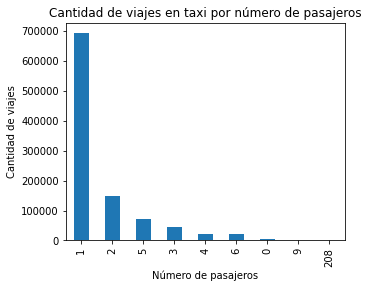

In [69]:
df_s["passenger_count"].value_counts().plot(kind="bar", figsize=(5, 4))
plt.xlabel("Número de pasajeros")
plt.ylabel("Cantidad de viajes")
plt.title("Cantidad de viajes en taxi por número de pasajeros")

Filtramos :  $ ~~0\leq \text{passenger_count}<8$

In [63]:
df_s["passenger_count"].between(0,7).value_counts() # Return boolean Series equivalent to left <= series <= right.

True     999991
False         2
Name: passenger_count, dtype: int64

**TARIFA DEL VIAJE**

Descripción de la columna monto de la tarifa (**fare_amount**)

In [72]:
df_s.fare_amount.describe()

count    1000000.000000
mean          11.327786
std            9.815542
min          -52.000000
25%            6.000000
50%            8.500000
75%           12.500000
max          850.000000
Name: fare_amount, dtype: float64

Text(0.5, 1.0, 'Frecuencia de las tarifas de los viajes en intervalos (k,5+k], $k=0,5,10,...}$')

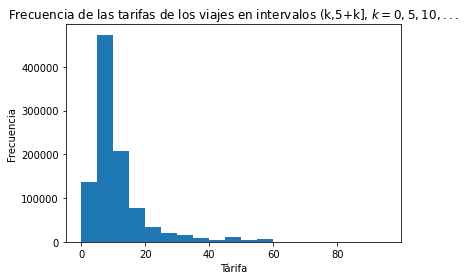

In [90]:
df_s["fare_amount"].plot.hist(alpha=1, stacked=True, bins=list(range(0, 100, 5)))
plt.xlabel("Tárifa")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de las tarifas de los viajes en intervalos (k,5+k], $k=0,5,10,...}$")

Filtramos :  $~~2\leq \text{fare_amount}\leq 200$

In [58]:
df_s[(df_s['fare_amount'] < 0)].shape # negativos

(56, 8)

In [64]:
df_s[(df_s['fare_amount'] > 0) & (df_s['fare_amount'] < 2)].shape # entre 0 y 2

(13, 8)

In [55]:
df_s[(df_s['fare_amount'] > 200)].shape # mayores de 200

(36, 8)

In [65]:
df_s["fare_amount"].between(2,200).value_counts()

True     999859
False       134
Name: fare_amount, dtype: int64

In [70]:
# Se trabajará con la siguiente data:
# Region: New York
# 
data = df_s[(-74.252444 <= df_s["pickup_longitude"]) & (df_s["pickup_longitude"] <= -73.629885) &
            (40.497175 <= df_s["pickup_latitude"]) & (df_s["pickup_latitude"] <= 40.825076) & 
            (-74.252444 <= df_s["dropoff_longitude"]) & (df_s["dropoff_longitude"] <= -73.629885) &
            (40.497175 <= df_s["dropoff_latitude"]) & (df_s["dropoff_latitude"] <= 40.825076)&
            (2.0 <= df_s["fare_amount"]) & (df_s["fare_amount"] <= 200) & 
            (0.0 < df_s["passenger_count"]) & (df_s["passenger_count"] <= 6) &
            (df_s["pickup_longitude"] != df_s["dropoff_longitude"])]

data ['pickup_datetime'] = pd.to_datetime(data.pickup_datetime) # convertimos a tipo de dato de datetime
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour
data['weekday'] = data['pickup_datetime'].dt.weekday

data.drop(columns='key', inplace=True)
data.drop(columns='pickup_datetime', inplace=True)

data.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
330111,5.3,-73.992143,40.753490,-73.985512,40.762957,4,2010,5,8,20,5
663520,15.3,-73.995700,40.760400,-73.988400,40.733600,1,2011,9,23,15,4
525009,5.0,-73.974800,40.787815,-73.966408,40.795776,3,2015,6,11,10,3
199449,13.0,-73.989952,40.729907,-73.973650,40.754865,1,2013,3,13,9,2
978049,9.5,-73.981136,40.781644,-73.954913,40.802622,1,2014,11,17,6,0


In [12]:
data.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
count,9.519430e+05,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000
mean,2.771951e+07,11.126503,-73.975861,40.750600,-73.975297,40.750089,1.689677,2011.743266,6.265574,15.699261,13.523608,3.041536
std,1.600850e+07,9.208447,0.033844,0.026220,0.033213,0.028829,1.304833,1.866433,3.435871,8.674179,6.494233,1.949093
min,7.000000e+01,2.500000,-74.250388,40.506347,-74.251572,40.504980,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,1.384565e+07,6.000000,-73.992341,40.736520,-73.991705,40.735232,1.000000,2010.000000,3.000000,8.000000,9.000000,1.000000
50%,2.770596e+07,8.500000,-73.982180,40.753192,-73.980877,40.753472,1.000000,2012.000000,6.000000,16.000000,14.000000,3.000000
75%,4.158751e+07,12.500000,-73.968697,40.767227,-73.966455,40.767776,2.000000,2013.000000,9.000000,23.000000,19.000000,5.000000
max,5.542384e+07,200.000000,-73.631367,40.825055,-73.632115,40.825076,6.000000,2015.000000,12.000000,31.000000,23.000000,6.000000


In [13]:
data.shape

(951943, 12)

In [14]:
data.sort_values(by='pickup_longitude', ascending=False).tail(5)

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
119750,42187142,35.7,-74.236065,40.774652,-74.243035,40.775842,4,2011,1,11,19,1
202355,37365669,3.3,-74.237608,40.775825,-74.239608,40.775108,5,2010,11,3,19,2
585848,29068103,7.3,-74.238963,40.775562,-74.239852,40.775577,2,2011,5,24,11,1
508139,49644569,16.5,-74.239403,40.762333,-74.245288,40.726913,1,2009,8,26,19,2
49700,11414830,36.9,-74.250388,40.776073,-74.245213,40.792067,1,2011,11,18,15,4


<AxesSubplot:>

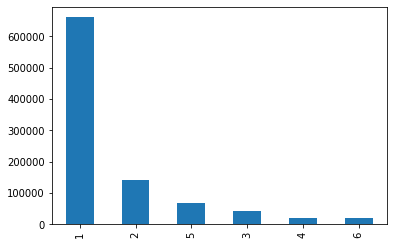

In [15]:
data["passenger_count"].value_counts().plot(kind="bar")

<AxesSubplot:xlabel='fare_amount', ylabel='Frequency'>

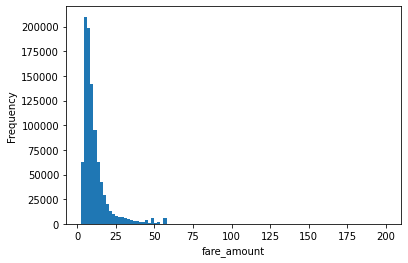

In [16]:
plt.xlabel("fare_amount")
data["fare_amount"].plot.hist(alpha=1, stacked=True, bins=100)

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

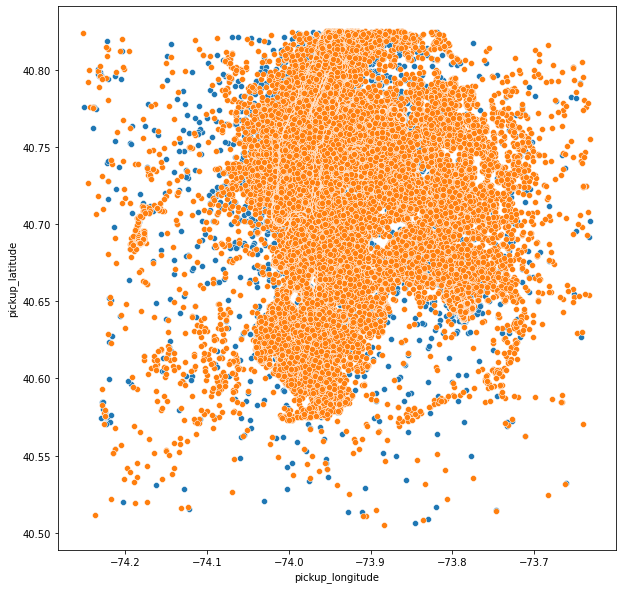

In [17]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data["pickup_longitude"], data["pickup_latitude"])
sns.scatterplot(data["dropoff_longitude"], data["dropoff_latitude"])

In [18]:
data.isna().sum(), data.isnull().sum()

(Unnamed: 0           0
 fare_amount          0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    0
 dropoff_latitude     0
 passenger_count      0
 year                 0
 month                0
 day                  0
 hour                 0
 weekday              0
 dtype: int64,
 Unnamed: 0           0
 fare_amount          0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    0
 dropoff_latitude     0
 passenger_count      0
 year                 0
 month                0
 day                  0
 hour                 0
 weekday              0
 dtype: int64)

<h4>Ingeniería de Características</h4>

In [19]:
#Distancia entre dos puntos (Métrica de Haversine)
# two ways 
# 1  : Using the package

#from haversine import haversine
#origin = (39.50, 98.35)
#paris = (48.8567, 2.3508)
#haversine(origin, paris, miles=False) # return the distance in km

# 2 def a function

def radian(sexag):
    return sexag*(pi/180.0)

def Haversine(lat1,lon1,lat2,lon2):
    if (lat1 == lat2 and lon1 == lon2):
        return 0.0001 # por mientras
    diffLat = radian(lat2-lat1)
    diffLon = radian(lon2-lon1)
    h = sin(diffLat/2) ** 2 + cos(radian(lat1))*cos(radian(lat2))*(sin(diffLon/2)**2)
    dKm = 2.0 * 6371.345 * asin(sqrt(h))
    return dKm 

#print(Haversine(39.50, 98.35, 48.8567, 2.3508))

data['distance'] = data.apply(lambda row: Haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
data.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,distance
count,9.519430e+05,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000
mean,2.771951e+07,11.126503,-73.975861,40.750600,-73.975297,40.750089,1.689677,2011.743266,6.265574,15.699261,13.523608,3.041536,3.251986
std,1.600850e+07,9.208447,0.033844,0.026220,0.033213,0.028829,1.304833,1.866433,3.435871,8.674179,6.494233,1.949093,3.432523
min,7.000000e+01,2.500000,-74.250388,40.506347,-74.251572,40.504980,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000084
25%,1.384565e+07,6.000000,-73.992341,40.736520,-73.991705,40.735232,1.000000,2010.000000,3.000000,8.000000,9.000000,1.000000,1.270145
50%,2.770596e+07,8.500000,-73.982180,40.753192,-73.980877,40.753472,1.000000,2012.000000,6.000000,16.000000,14.000000,3.000000,2.152730
75%,4.158751e+07,12.500000,-73.968697,40.767227,-73.966455,40.767776,2.000000,2013.000000,9.000000,23.000000,19.000000,5.000000,3.846501
max,5.542384e+07,200.000000,-73.631367,40.825055,-73.632115,40.825076,6.000000,2015.000000,12.000000,31.000000,23.000000,6.000000,37.437210


<h4> Definición del modelo a entrenar </h4>

In [20]:
%%time
predictors = ['distance']
salida = 'fare_amount'

X = data[predictors]
y = data[salida]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Imprime el b y lso coeficientes
print(f'Intercepto: {modelo.intercept_:.3f}')
print(f'Coeficientes: {modelo.coef_[0]:.3f}')

Intercepto: 3.426
Coeficientes: 2.370
CPU times: user 121 ms, sys: 20 ms, total: 141 ms
Wall time: 270 ms


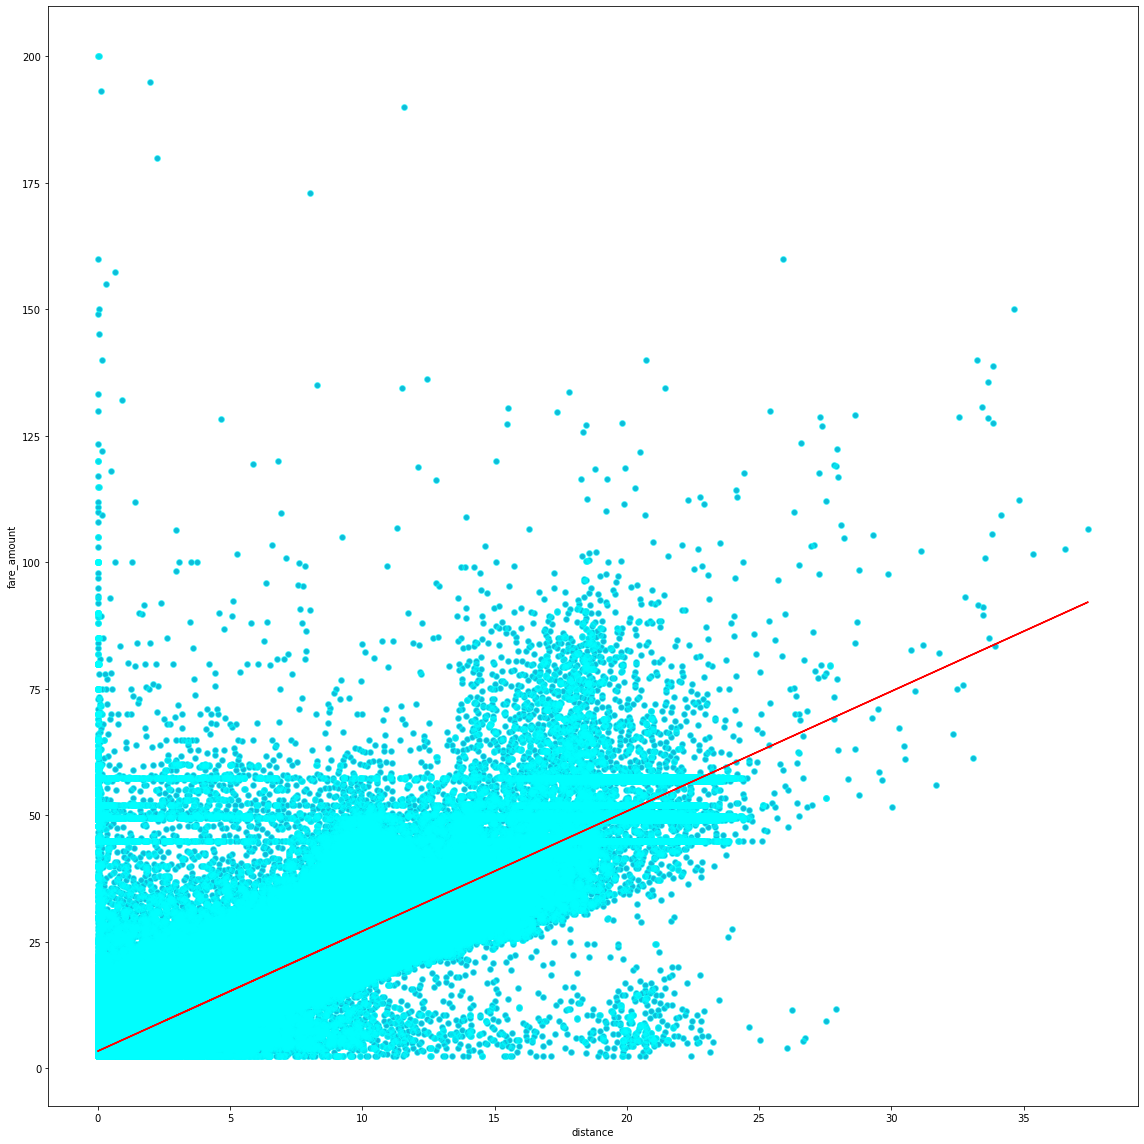

In [21]:
# comparo el valor predicho de todos los puntos dados con el calculado
fitted = modelo.predict(data[predictors])
residuals = data[salida] - fitted

ax = data.plot.scatter(x="distance", y="fare_amount", figsize=(16, 16))
ax.scatter(data.distance, data.fare_amount, alpha=0.5, c='aqua')
ax.plot(data.distance, fitted, c="red")
"""
for x, y_actual, y_fitted in zip(data.distance, data.fare_amount, fitted):
    ax.plot((x, x), (y_actual, y_fitted), "--", color="C1")
"""    
plt.tight_layout()
plt.show()

In [22]:
modelo.score(X_test, y_test)

0.7862454537282475

## Metrics

In [66]:
# datos de entrenamiento y el ajustado
r2score = r2_score(data[salida], fitted)
mse = mean_squared_error(data[salida], fitted)
rmse = sqrt(mean_squared_error(data[salida], fitted))

print("MSE", mse)
print("RMSE",rmse)
print("R2", r2score)

NameError: name 'data' is not defined